In [1]:
#My imports
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler
import math
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from codecarbon import OfflineEmissionsTracker
from sklearn.preprocessing import MinMaxScaler

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
import matplotlib.pyplot as plt

In [27]:
tracker= OfflineEmissionsTracker(country_iso_code= "IND")

In [2]:
# Reading the data:
nRowsRead = None
# METABRIC_RNA_Mutation.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/home/aryamanj/Downloads/METABRIC_RNA_Mutation.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'METABRIC_RNA_Mutation.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1904 rows and 693 columns


/home/aryamanj/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def parseY(dataset, target_columns, delim):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in target_columns:
            point.append(float(all_columns[i]))
        Y.append(point)
    Y_arr = np.asarray(Y)
    return Y_arr

In [4]:
clinicalData= "./METABRIC_clinical_1980.txt"
geneData= "./METABRIC_gene_exp_1980.txt"
cnvData= "METABRIC_cnv_1980.txt"
Clinical= parseY(clinicalData, range(25), "\t")
GeneExp= parseY(geneData, range(400), "\t")
CNV= parseY(cnvData, range(200), "\t")

In [31]:
"""
Processing code for KaggleClinical+Categorical GeneExp+CNV
"""

df2 = df1.drop(columns=['patient_id', 'cancer_type', 'cancer_type_detailed', 'cohort'])
df3 = df2[df2['her2_status_measured_by_snp6'] != 'UNDEF']
df3['er_status_measured_by_ihc'] = df3['er_status_measured_by_ihc'].apply(lambda x: 1 if "Positive" in str(x) else 0)
df3['her2_status'] = df3['her2_status'].apply(lambda x: 1 if "Positive" in str(x) else 0)
df3['inferred_menopausal_state'] = df3['inferred_menopausal_state'].apply(lambda x: 1 if "Post" in str(x) else 0)
df3['primary_tumor_laterality'] = df3['primary_tumor_laterality'].apply(lambda x: 1 if "Left" in str(x) else 0)
df3['pr_status'] = df3['pr_status'].apply(lambda x: 1 if "Positive" in str(x) else 0)
df3['er_status'] = df3['er_status'].apply(lambda x: 1 if "Positive" in str(x) else 0)
dummyList = ['cellularity',
             'pam50_+_claudin-low_subtype',
             'neoplasm_histologic_grade',
             #'cancer_type_detailed',
             'tumor_other_histologic_subtype',
             'integrative_cluster',
             #'gene_classifier_subtype',
             'oncotree_code',
             'her2_status_measured_by_snp6',
             '3-gene_classifier_subtype',
             'death_from_cancer'
            ]
df4 = pd.get_dummies(df3, columns=dummyList)
df4['type_of_breast_surgery'] = df4['type_of_breast_surgery'].apply(lambda x: 1 if "MASTECTOMY" in str(x) else 0)
# df5 = df4.applymap(lambda x: 0 if "0" in str(x) else 1)
y = df4["death_from_cancer_Died of Disease"]
X = df4.drop(columns=["overall_survival", "death_from_cancer_Died of Other Causes", "death_from_cancer_Living", "death_from_cancer_Died of Disease"])
clinicalDF= X.iloc[:,:17] # collect relevant clinical modality
clinicalDF["y"]= df4["death_from_cancer_Died of Disease"] # adding labels to existing dataFrame
clinicalDF["dummyTuple"]= list(zip(clinicalDF.age_at_diagnosis, clinicalDF.nottingham_prognostic_index)) # constructing column to use for ordering
# Loading data from .txt files
textClinical= pd.DataFrame(data= Clinical)
textGeneExp= pd.DataFrame(data= GeneExp)
textCNV= pd.DataFrame(data= CNV)
textClinical["dummyTuple"]= list(zip(textClinical[4], textClinical[6])) # constructing equivalent index column for the .txt data
textCombined= pd.concat([textGeneExp, textCNV], axis= 1) # combining GeneExp and CNV .txt data
textCombined["dummyTuple"]= textClinical["dummyTuple"] # appending constructed index to the combined dataFrame
tmp= textCombined.dummyTuple.isin(clinicalDF.dummyTuple).astype(int) # for checking which terms don't match up
tmp_= clinicalDF.dummyTuple.isin(textCombined.dummyTuple).astype(int) # "" "" "" 
textCombined['tmp']= tmp # appending this mask
clinicalDF['tmp']= tmp_
textCombined= textCombined[textCombined['tmp'] == 1] # selectively removing terms on the basis of this mask
clinicalDF= clinicalDF[clinicalDF['tmp'] == 1]
clinicalDF= clinicalDF.drop_duplicates(subset= ["dummyTuple"]) # duplicates exist in the formed index column -- dropping them
textCombined= textCombined.drop_duplicates(subset= ["dummyTuple"]) # "" "" "" "" 
clinicalDF= clinicalDF.set_index("dummyTuple") # reindexing kaggleClinical data on the basis of the index of the .txt data
clinicalDF= clinicalDF.reindex(index= textCombined['dummyTuple'])
clinicalDF= clinicalDF.reset_index()
textCombined= textCombined.reset_index() # resetting indices to ensure concatentation works as expected
finalDF= pd.concat([clinicalDF.drop(columns= ["dummyTuple", "tmp"]),textCombined.drop(columns= ["dummyTuple", "tmp"])], axis= 1)
# cleaning up resultant DF's
finalDF= finalDF.drop(columns= "index")
Y= finalDF["y"]
fullX= finalDF.drop(columns= "y")


/tmp/ipykernel_65438/3544158016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['er_status_measured_by_ihc'] = df3['er_status_measured_by_ihc'].apply(lambda x: 1 if "Positive" in str(x) else 0)
/tmp/ipykernel_65438/3544158016.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['her2_status'] = df3['her2_status'].apply(lambda x: 1 if "Positive" in str(x) else 0)
/tmp/ipykernel_65438/3544158016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [5]:
"""
Processing code for combined .txt files:
"""
textClinical= pd.DataFrame(data= Clinical)
scaler= MinMaxScaler()
toTransform= [4, 6, 9, 12]
for col in toTransform:
    textClinical[col]= scaler.fit_transform(textClinical[col].to_numpy().reshape(-1,1))
textCombined= pd.concat([pd.DataFrame(data= Clinical), pd.DataFrame(data= GeneExp), pd.DataFrame(data= CNV)], axis= 1, ignore_index= True)
fullX= textCombined.drop(columns= [0,1])
Y= textCombined[1]

In [6]:
# outputs 1720 if above code worked correctly
(clinicalDF["dummyTuple"] == textCombined["dummyTuple"]).sum()

NameError: name 'clinicalDF' is not defined

In [7]:
X_train, X_test, y_train, y_test = train_test_split(fullX, Y, test_size = 0.20)

In [8]:
fullX.iloc[:,:19]

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,1.0,0.285906,1.0,0.563433,1.0,1.0,0.000000,0.0,3.0,0.054945,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,3.0,1.0,0.362292,1.0,0.565299,1.0,1.0,0.022222,1.0,2.0,0.082418,2.0,0.0,1.0,1.0,4.0,0.0,1.0,0.0
2,9.0,1.0,0.346288,1.0,0.569030,1.0,1.0,0.066667,1.0,2.0,0.137363,2.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0
3,7.0,1.0,0.764389,0.0,0.571269,1.0,0.0,0.000000,1.0,3.0,0.170330,4.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4,3.0,1.0,0.464228,1.0,0.563433,1.0,0.0,0.022222,0.0,2.0,0.054945,2.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,5.0,1.0,0.393491,1.0,0.755970,1.0,0.0,0.022222,0.0,3.0,0.142857,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0
1976,8.0,1.0,0.375740,0.0,0.758582,1.0,1.0,0.400000,0.0,2.0,0.181319,4.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1977,5.0,1.0,0.236686,1.0,0.752239,0.0,1.0,0.022222,0.0,3.0,0.087912,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0
1978,0.0,1.0,0.538731,1.0,0.957090,1.0,0.0,0.511111,1.0,3.0,0.357143,3.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0


In [22]:
batch_is= 64
# creating torch dataLoaders:
train_dataset = data_utils.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(y_train.to_numpy()))
test_dataset = data_utils.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(y_test.to_numpy()))
train_loader= data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader= data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

In [9]:
# Loss function code:
def bareCDF(yhat, tau):
    # yhat is a torch tensor, tau is a float
    ind= (torch.sign(yhat)+1)/2 # mask about the origin
    quantFactor= (1-tau)*ind + tau*(1-ind)
    val= tau+4*quantFactor/math.pi*torch.atan(torch.tanh(yhat/2))
    # print("bareCDF val: {}".format(val))
    return val

def baresBQR(y, yhat, tau):
    # y and yhat are torch tensors, tau is a float
    val= torch.matmul(y,torch.log(1-bareCDF(yhat, tau)))+ torch.matmul((1-y),torch.log(bareCDF(yhat, tau)))
    # print("bareBQR val: {}".format(val))
    return val

class sBQRL(nn.Module):
    def __init__(self):
        super(sBQRL, self).__init__()
    
    def forward(self, y, yhat, tau):
        return baresBQR(y, yhat, tau)


In [10]:
# Network definition:
class LALRnetwork(nn.Module):
    def __init__(self, indim):
        super(LALRnetwork,self).__init__()
        self.l1 = nn.Linear(indim,1500)
        self.l2 = nn.Linear(1500,1500)
        self.l3 = nn.Linear(1500,1)
        
    def forward(self,x):
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        # x = F.softmax(self.l3(x))
        x = F.sigmoid(self.l3(x))
        # x= torch.sign(x-torch.ones_like(x)*0.5)
        # x= (x+torch.ones_like(x))/2
        return x
    
    # Used in LALR
    def penU(self, x):
        op = F.tanh(self.l1(x))
        op = F.tanh(self.l2(op))
        return op


In [23]:
# Global initialisations:
device= ('cuda' if torch.cuda.is_available() else 'cpu')
indim = X_train.shape[1]
modelLALR_sBQC = LALRnetwork(indim).to(device)
modelCLR_sBQC= LALRnetwork(indim).to(device)
modelLALR_BCE= LALRnetwork(indim).to(device)
modelCLR_BCE= LALRnetwork(indim).to(device)
modelLBFGS_sBQC = LALRnetwork(indim).to(device)

criterion= sBQRL()
criterion_= nn.BCELoss()
h= 0.4
lr_is = 1e-2
optimizerLALR_sBQC= torch.optim.Adam(modelLALR_sBQC.parameters(), lr = lr_is)
optimizerLALR_BCE= torch.optim.Adam(modelLALR_BCE.parameters(), lr = lr_is)
optimizerCLR_sBQC= torch.optim.Adam(modelCLR_sBQC.parameters(), lr = lr_is)
optimizerCLR_BCE= torch.optim.Adam(modelCLR_BCE.parameters(), lr = lr_is)
optimizerLBFGS_sBQC= torch.optim.LBFGS(modelLBFGS_sBQC.parameters(), lr = lr_is)

all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0
tau= 0.2

ls_list_LALR_sBQC= []
val_list_LALR_sBQC= []
acc_list_LALR_sBQC= []
ls_list_CLR_sBQC= []
val_list_CLR_sBQC= []
acc_list_CLR_sBQC= []
ls_list_LALR_BCE= []
val_list_LALR_BCE= []
acc_list_LALR_BCE= []
ls_list_CLR_BCE= []
val_list_CLR_BCE= []
acc_list_CLR_BCE= []

ls_list_LBFGS_sBQC= []
val_list_LBFGS_sBQC= []
acc_list_LBFGS_sBQC= []

In [24]:
# training loops:
def trainConstantLR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, loss_name= "sBQC"):
    """
    Training loop used for CLR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader),
         float(num_correct)/float(total)*100))


def trainLALR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, mask, loss_name= "sBQC"):
    """
    Training loop used for LALR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        lr_val= computeLR(model,train_loader, mask, tau, bSize= batch_is)
        optimizer.param_groups[0]['lr']= lr_val
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion_(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} LR: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader), optimizer.param_groups[0]['lr'], float(num_correct)/float(total)*100))

def trainLBFGS(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, loss_name= "sBQC"):
    """
    Training loop used for LBFGS and conjugate gradient training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            def closure():
                optimizer.zero_grad()
                outputs= model(inputs)
                if loss_name== "BCE":
                    loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
                elif loss_name== "sBQC":
                    loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
                loss.backward()
                return loss
            optimizer.step(closure) 

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader),
         float(num_correct)/float(total)*100))


def computeLR(model, trainLoader, mask, tau, bSize= 16):
    """
    Takes in a network of the LALRnetwork class(during some arbitrary EPOCH of training) and the current input, and returns Kz for the EPOCH
    """
    Kz = 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(trainLoader):
            inputs,labels= j[0],j[1]
            inputs= inputs.to(device)
            labels= labels.to(device)
            op1= model.penU(inputs)
            op2= model(inputs)
            val1= torch.linalg.norm(op1)
            if val1 > Kz:
                Kz= val1 
    LR= 1
    factor= 1
    if mask== 1: 
        LR=  max(2/math.pi, 2-2*tau/(math.pi*tau), 2*tau/(math.pi*(1-tau)))*Kz*(1/bSize)
        # factor= 0.15
    else:
        LR= 0.5*Kz*(1/bSize)
        # factor= 0.05

    return (1/LR)*factor

In [40]:
trainLBFGS(modelLBFGS_sBQC, train_loader, test_loader, optimizerLBFGS_sBQC, criterion, tau, 10, ls_list_LBFGS_sBQC, val_list_LBFGS_sBQC, acc_list_LBFGS_sBQC, "sBQC")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [35]:
# LALR, sBQC
# tracker.start()
trainLALR(modelLALR_sBQC, train_loader, test_loader, optimizerLALR_sBQC, criterion, tau, 10, ls_list_LALR_sBQC, val_list_LALR_sBQC, acc_list_LALR_sBQC, 1, "sBQC")
# emissions= tracker.stop()
# print(emissions)

Epoch: 0 Training Loss: -54.2373664855957 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 1 Training Loss: -54.23736602783203 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 2 Training Loss: -54.23736633300781 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 3 Training Loss: -54.23736602783203 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 4 Training Loss: -54.23736572265625 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 5 Training Loss: -54.23736602783203 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 6 Training Loss: -54.237366638183595 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 7 Training Loss: -54.23736572265625 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 8 Training Loss: -54.23736633300781 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


Epoch: 9 Training Loss: -54.23736572265625 Validation loss: -48.90763977595738 LR: 0.15150514245033264 Accuracy: 67.92929292929293


In [21]:
tracker= OfflineEmissionsTracker(country_iso_code= "IND")

In [37]:
# CLR, sBQC
# tracker.start()
trainConstantLR(modelCLR_sBQC, train_loader, test_loader, optimizerCLR_sBQC, criterion, tau, 10, ls_list_CLR_sBQC, val_list_CLR_sBQC, acc_list_CLR_sBQC, "sBQC")
# emissions= tracker.stop()
# print(emissions)

Epoch: 0 Training Loss: -52.99820724487304 Validation loss: -46.98584883553641 Accuracy: 66.66666666666666


Epoch: 1 Training Loss: -52.998207550048825 Validation loss: -46.98583085196359 Accuracy: 66.66666666666666


Epoch: 2 Training Loss: -52.99820693969727 Validation loss: -46.98581177847726 Accuracy: 66.66666666666666


Epoch: 3 Training Loss: -52.99820739746094 Validation loss: -46.985786710466655 Accuracy: 66.66666666666666


Epoch: 4 Training Loss: -52.99820663452149 Validation loss: -46.98576818193708 Accuracy: 66.66666666666666


Epoch: 5 Training Loss: -52.998206329345706 Validation loss: -46.98575292314802 Accuracy: 66.66666666666666


Epoch: 6 Training Loss: -52.998206787109375 Validation loss: -46.98573330470494 Accuracy: 66.66666666666666


Epoch: 7 Training Loss: -52.998207092285156 Validation loss: -46.98571695600237 Accuracy: 66.66666666666666


Epoch: 8 Training Loss: -52.998207092285156 Validation loss: -46.985700607299805 Accuracy: 66.66666666666666


Epoch: 9 Training Loss: -52.998206787109375 Validation loss: -46.98568207877023 Accuracy: 66.66666666666666


In [39]:
# LALR BCE
trainLALR(modelLALR_BCE, train_loader, test_loader, optimizerLALR_BCE, criterion_, tau, 10, ls_list_LALR_BCE, val_list_LALR_BCE, acc_list_LALR_BCE, 2, "BCE")

Epoch: 0 Training Loss: 32.45833343505859 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 1 Training Loss: 32.45833343505859 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 2 Training Loss: 32.375 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 3 Training Loss: 32.5625 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 4 Training Loss: 32.5 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 5 Training Loss: 32.479166717529296 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 6 Training Loss: 32.39583335876465 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 7 Training Loss: 32.416666717529296 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 8 Training Loss: 32.375 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


Epoch: 9 Training Loss: 32.45833343505859 Validation loss: 34.30059541974749 LR: 0.41311824321746826 Accuracy: 66.66666666666666


In [40]:
# CLR BCE
trainConstantLR(modelCLR_BCE, train_loader, test_loader, optimizerCLR_BCE, criterion_, tau, 10, ls_list_CLR_BCE, val_list_CLR_BCE, acc_list_CLR_BCE, "BCE")

Epoch: 0 Training Loss: 0.1559533405303955 Validation loss: 1.6228360789162772 Accuracy: 64.39393939393939


Epoch: 1 Training Loss: 0.12344533950090408 Validation loss: 1.706842643874032 Accuracy: 65.65656565656566


Epoch: 2 Training Loss: 0.10109413743019104 Validation loss: 2.0157253742218018 Accuracy: 68.43434343434343


Epoch: 3 Training Loss: 0.09247495770454407 Validation loss: 2.4977846145629883 Accuracy: 61.61616161616161


Epoch: 4 Training Loss: 0.07711075592786074 Validation loss: 3.0457121644701277 Accuracy: 68.43434343434343


Epoch: 5 Training Loss: 0.05175116047263145 Validation loss: 4.591686402048383 Accuracy: 64.39393939393939


Epoch: 6 Training Loss: 0.025274073742330073 Validation loss: 4.294656566211155 Accuracy: 68.43434343434343


Epoch: 7 Training Loss: 0.015890953028574586 Validation loss: 3.132297158241272 Accuracy: 64.39393939393939


Epoch: 8 Training Loss: 0.010366284605115652 Validation loss: 4.545402032988412 Accuracy: 65.40404040404042


Epoch: 9 Training Loss: 0.006581745324656368 Validation loss: 4.626339537756784 Accuracy: 66.41414141414141


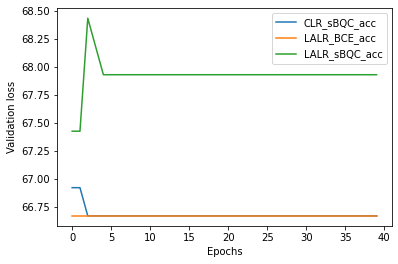

In [44]:
# error plots
# plt.plot(range(10), ls_list_LALR_sBQC)
# plt.plot(range(len(val_list_LALR_sBQC)), val_list_LALR_sBQC, label= "LALR_sBQC")
# plt.plot(range(len(val_list_CLR_sBQC)), val_list_CLR_sBQC, label= "CLR_sBQC")
# plt.plot(range(len(val_list_LALR_BCE)), val_list_LALR_BCE, label= "LALR_BCE")
# plt.plot(range(len(val_list_CLR_BCE)), val_list_CLR_BCE, label= "CLR_BCE")
# plt.plot(range(len(acc_list_CLR_BCE)), acc_list_CLR_BCE, label= "CLR_BCE_acc")
plt.plot(range(len(acc_list_CLR_sBQC)), acc_list_CLR_sBQC, label= "CLR_sBQC_acc")
plt.plot(range(len(acc_list_LALR_BCE)), acc_list_LALR_BCE, label= "LALR_BCE_acc")
plt.plot(range(len(acc_list_LALR_sBQC)), acc_list_LALR_sBQC, label= "LALR_sBQC_acc")
# plt.plot(range(len(val_list_LBFGS_sBQC)), val_list_LBFGS_sBQC, label= "LBFGS_sBQC_val")
# plt.plot(range(len(acc_list_LBFGS_sBQC)), acc_list_LBFGS_sBQC, label= "LBFGS_sBQC_acc")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.legend()